# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [60]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ttest_ind, levene
import seaborn as sns
import math

DATA_PATH_CALLS = '/datasets/megaline_calls.csv'
DATA_PATH_INTERNET = '/datasets/megaline_internet.csv'
DATA_PATH_MESSAGES = '/datasets/megaline_messages.csv'
DATA_PATH_PLANS = '/datasets/megaline_plans.csv'
DATA_PATH_USERS = '/datasets/megaline_users.csv'


## Cargar datos

In [61]:
calls = pd.read_csv(DATA_PATH_CALLS)
internet = pd.read_csv(DATA_PATH_INTERNET)
messages = pd.read_csv(DATA_PATH_MESSAGES)
plans = pd.read_csv(DATA_PATH_PLANS)
users = pd.read_csv(DATA_PATH_USERS)

print('calls', calls.shape)
print('internet', internet.shape)
print('messages', messages.shape)
print('plans', plans.shape)
print('users', users.shape)



calls (137735, 4)
internet (104825, 4)
messages (76051, 3)
plans (2, 8)
users (500, 8)


## Preparar los datos

In [62]:

calls['call_date'] = pd.to_datetime(calls['call_date'], errors='coerce')
internet['session_date'] = pd.to_datetime(internet['session_date'], errors='coerce')
messages['message_date'] = pd.to_datetime(messages['message_date'], errors='coerce')
users['reg_date'] = pd.to_datetime(users['reg_date'], dayfirst=True, errors='coerce')
users['churn_date'] = pd.to_datetime(users['churn_date'], dayfirst=True, errors='coerce')


calls['month'] = calls['call_date'].dt.to_period('M')
internet['month'] = internet['session_date'].dt.to_period('M')
messages['month'] = messages['message_date'].dt.to_period('M')


calls['duration'] = pd.to_numeric(calls['duration'], errors='coerce').fillna(0)
internet['mb_used'] = pd.to_numeric(internet['mb_used'], errors='coerce').fillna(0)


calls = calls[calls['user_id'].notna()]
messages = messages[messages['user_id'].notna()]
internet = internet[internet['user_id'].notna()]


print('\nNulos en users:\n', users.isna().sum())
print('\nNulos en plans:\n', plans.isna().sum())


plans = plans.rename(columns={'plan_name':'plan'})




Nulos en users:
 user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64

Nulos en plans:
 messages_included        0
mb_per_month_included    0
minutes_included         0
usd_monthly_pay          0
usd_per_gb               0
usd_per_message          0
usd_per_minute           0
plan_name                0
dtype: int64


## Tarifas

In [63]:
plans.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan                   2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [64]:
plans.describe(include='all')


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan
count,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ultimate
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
mean,525.000000,23040.000000,1750.000000,45.000000,8.50000,0.020000,0.020000,NaN
std,671.751442,10861.160159,1767.766953,35.355339,2.12132,0.014142,0.014142,NaN
min,50.000000,15360.000000,500.000000,20.000000,7.00000,0.010000,0.010000,NaN
25%,287.500000,19200.000000,1125.000000,32.500000,7.75000,0.015000,0.015000,NaN
50%,525.000000,23040.000000,1750.000000,45.000000,8.50000,0.020000,0.020000,NaN
75%,762.500000,26880.000000,2375.000000,57.500000,9.25000,0.025000,0.025000,NaN


In [65]:
plans.head()


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


El DataFrame de tarifas está completo y sin valores ausentes, con tipos de datos correctos para cada variable. La información coincide con la descripción de los planes: Surf incluye 500 minutos, 50 SMS y 15 GB de datos por 20 USD mensuales, mientras que Ultimate ofrece 3000 minutos, 1000 SMS y 30 GB por 70 USD. Dado que los volúmenes de datos se expresan en megabytes, será útil convertirlos también a gigabytes para un análisis más claro. Además, se recomienda renombrar la columna plan_name a plan para facilitar la integración con la tabla de usuarios.

## Corregir datos

In [66]:
# Renombramos la columna plan_name a plan para que sea consistente con la tabla de usuarios
plans.rename(columns={'plan_name': 'plan'}, inplace=True)

# Creamos una columna adicional con los datos incluidos expresados en GB (para análisis más claros)
plans['gb_included'] = (plans['mb_per_month_included'] / 1024).astype(int)

# Revisamos los cambios
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan,gb_included
0,50,15360,500,20,10,0.03,0.03,surf,15
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30


## Enriquecer los datos

In [67]:
# Como enriquecimiento adicional podemos calcular el costo por unidad de cada recurso incluido
# Esto nos permitirá comparaciones más rápidas en el análisis

plans['usd_per_minute_included'] = plans['usd_monthly_pay'] / plans['minutes_included']
plans['usd_per_message_included'] = plans['usd_monthly_pay'] / plans['messages_included']
plans['usd_per_gb_included'] = plans['usd_monthly_pay'] / plans['gb_included']

# Vista final
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan,gb_included,usd_per_minute_included,usd_per_message_included,usd_per_gb_included
0,50,15360,500,20,10,0.03,0.03,surf,15,0.040000,0.40,1.333333
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30,0.023333,0.07,2.333333


## Usuarios/as

In [68]:
users.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [69]:
users.head()


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT


La tabla de usuarios contiene información básica como el identificador (user_id), nombre, edad, ciudad de residencia, fecha de registro, plan contratado y la fecha de cancelación del servicio (churn_date). Las fechas están correctamente convertidas al formato datetime y se observa que muchos usuarios tienen churn_date vacío, lo cual significa que seguían activos al momento de la extracción de datos. No se aprecian valores ausentes críticos ni inconsistencias evidentes, aunque es recomendable mantener la bandera de cancelación (churn_flag) como variable derivada para futuros análisis de retención.

### Corregir los datos

In [70]:
# Convertir fechas a tipo datetime
users['reg_date'] = pd.to_datetime(users['reg_date'], errors='coerce')
users['churn_date'] = pd.to_datetime(users['churn_date'], errors='coerce')

# Verificar valores nulos
print("Valores nulos por columna:")
print(users.isna().sum())

# Eliminar duplicados en caso de que existan
users.drop_duplicates(inplace=True)

# Vista final después de la corrección
users.info()

Valores nulos por columna:
user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 35.2+ KB


### Enriquecer los datos

In [71]:
# Crear columna con el año-mes de registro para análisis de cohortes
users['reg_month'] = users['reg_date'].dt.to_period('M')

# Crear una bandera de cancelación: 1 si el usuario canceló, 0 si sigue activo
users['churn_flag'] = users['churn_date'].notna().astype(int)

# Vista de los datos enriquecidos
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,reg_month,churn_flag
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,2018-12,0
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,2018-08,0
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT,2018-10,0
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT,2018-01,0
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT,2018-05,0


## Llamadas

In [72]:
calls.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 137735 entries, 0 to 137734
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
 4   month      137735 non-null  period[M]     
dtypes: datetime64[ns](1), float64(1), int64(1), object(1), period[M](1)
memory usage: 6.3+ MB


In [73]:
calls.head()


,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,8.52,2018-12
1,1000_145,1000,2018-12-27,13.66,2018-12
2,1000_247,1000,2018-12-27,14.48,2018-12
3,1000_309,1000,2018-12-28,5.76,2018-12
4,1000_380,1000,2018-12-30,4.22,2018-12


La muestra de datos confirma que cada registro de llamada tiene un identificador único (`id`), 
asociado a un usuario (`user_id`), con su fecha (`call_date`), duración en minutos (`duration`) 
y el mes correspondiente (`month`). El esquema es consistente y no presenta valores ausentes. 
Las duraciones son valores enteros positivos, aunque más adelante será necesario verificar y 
eliminar los casos con `duration = 0`, que corresponden a intentos fallidos o llamadas no completadas. 
En general, la tabla se encuentra en buen estado y lista para la fase de limpieza.

### Corregir los datos

In [74]:
# Eliminar llamadas con duración igual a 0
calls = calls[calls['duration'] > 0]

# Verificamos que ya no existan registros con duración 0
print("Registros restantes:", calls.shape[0])
print("Duraciones mínimas:", calls['duration'].min())

Registros restantes: 110901
Duraciones mínimas: 0.01


### Enriquecer los datos

In [75]:
# Crear nueva columna con duración redondeada hacia arriba
calls['duration_ceil'] = np.ceil(calls['duration']).astype(int)

# Vista previa
calls.head()

,id,user_id,call_date,duration,month,duration_ceil
0,1000_93,1000,2018-12-27,8.52,2018-12,9
1,1000_145,1000,2018-12-27,13.66,2018-12,14
2,1000_247,1000,2018-12-27,14.48,2018-12,15
3,1000_309,1000,2018-12-28,5.76,2018-12,6
4,1000_380,1000,2018-12-30,4.22,2018-12,5


## Mensajes

In [76]:
messages.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 76051 entries, 0 to 76050
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
 3   month         76051 non-null  period[M]     
dtypes: datetime64[ns](1), int64(1), object(1), period[M](1)
memory usage: 2.9+ MB


In [77]:
messages.head()


,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,2018-12
1,1000_160,1000,2018-12-31,2018-12
2,1000_223,1000,2018-12-31,2018-12
3,1000_251,1000,2018-12-27,2018-12
4,1000_255,1000,2018-12-26,2018-12


La tabla de mensajes contiene 76,051 registros, cada uno identificado de manera única por un id y asociado a un user_id. Además, se registra la fecha del envío (message_date) y el mes (month), lo cual facilitará el análisis mensual. No se presentan valores ausentes y los tipos de datos son correctos: fechas en formato datetime, meses en period[M] y los identificadores como texto o enteros. En general, la tabla está en buen estado y lista para el análisis, sin necesidad de aplicar correcciones adicionales.

### Corregir los datos

In [78]:
# Eliminar duplicados si existieran
messages = messages.drop_duplicates()

# Verificar nuevamente la cantidad de registros
print("Registros después de eliminar duplicados:", messages.shape[0])

Registros después de eliminar duplicados: 76051


### Enriquecer los datos

In [79]:
# Crear columna con el día de la semana
messages['weekday'] = messages['message_date'].dt.day_name()

# Vista previa
messages.head()

,id,user_id,message_date,month,weekday
0,1000_125,1000,2018-12-27,2018-12,Thursday
1,1000_160,1000,2018-12-31,2018-12,Monday
2,1000_223,1000,2018-12-31,2018-12,Monday
3,1000_251,1000,2018-12-27,2018-12,Thursday
4,1000_255,1000,2018-12-26,2018-12,Wednesday


## Internet

In [80]:
internet.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 104825 entries, 0 to 104824
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
 4   month         104825 non-null  period[M]     
dtypes: datetime64[ns](1), float64(1), int64(1), object(1), period[M](1)
memory usage: 4.8+ MB


In [81]:
internet.head()


,id,user_id,session_date,mb_used,month
0,1000_13,1000,2018-12-29,89.86,2018-12
1,1000_204,1000,2018-12-31,0.00,2018-12
2,1000_379,1000,2018-12-28,660.40,2018-12
3,1000_413,1000,2018-12-26,270.99,2018-12
4,1000_442,1000,2018-12-27,880.22,2018-12


La tabla de sesiones de Internet contiene 104,825 registros, cada uno identificado por un id único y vinculado a un user_id. Incluye la fecha de la sesión (session_date), el tráfico en MB consumido (mb_used) y el mes (month). Los tipos de datos son correctos (datetime, float, period[M]), y no se observan valores nulos. Sin embargo, existen registros con mb_used = 0, que pueden corresponder a sesiones fallidas o sin consumo real de datos; estos casos deberán evaluarse para decidir si se eliminan o se mantienen. En general, el dataset es consistente y se encuentra en buen estado para su análisis.

### Corregir los datos

In [82]:
# Eliminar duplicados
internet = internet.drop_duplicates()

# Revisar cuántos registros tienen mb_used = 0
zero_sessions = internet[internet['mb_used'] == 0]
print("Registros con mb_used = 0:", zero_sessions.shape[0])

# Eliminar registros sin consumo real de datos
internet = internet[internet['mb_used'] > 0].copy()

print("Total de registros después de correcciones:", internet.shape[0])

Registros con mb_used = 0: 13747
Total de registros después de correcciones: 91078


### Enriquecer los datos

In [83]:
# Crear columna con el día de la semana
internet['weekday'] = internet['session_date'].dt.day_name()

# Crear columna con consumo en GB
internet['gb_used'] = internet['mb_used'] / 1024

# Vista previa de los datos enriquecidos
internet.head()

,id,user_id,session_date,mb_used,month,weekday,gb_used
0,1000_13,1000,2018-12-29,89.86,2018-12,Saturday,0.087754
2,1000_379,1000,2018-12-28,660.40,2018-12,Friday,0.644922
3,1000_413,1000,2018-12-26,270.99,2018-12,Wednesday,0.264639
4,1000_442,1000,2018-12-27,880.22,2018-12,Thursday,0.859590
5,1001_0,1001,2018-08-24,284.68,2018-08,Friday,0.278008


## Estudiar las condiciones de las tarifas

In [84]:
plans.info()
print("\n")
print(plans)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   messages_included         2 non-null      int64  
 1   mb_per_month_included     2 non-null      int64  
 2   minutes_included          2 non-null      int64  
 3   usd_monthly_pay           2 non-null      int64  
 4   usd_per_gb                2 non-null      int64  
 5   usd_per_message           2 non-null      float64
 6   usd_per_minute            2 non-null      float64
 7   plan                      2 non-null      object 
 8   gb_included               2 non-null      int64  
 9   usd_per_minute_included   2 non-null      float64
 10  usd_per_message_included  2 non-null      float64
 11  usd_per_gb_included       2 non-null      float64
dtypes: float64(5), int64(6), object(1)
memory usage: 320.0+ bytes


   messages_included  mb_per_month_included  minutes_include

## Agregar datos por usuario



In [85]:
calls_per_user = calls.groupby(['user_id', 'month']).agg(calls_count=('id', 'count')).reset_index()
calls_per_user.head()


,user_id,month,calls_count
0,1000,2018-12,16
1,1001,2018-08,22
2,1001,2018-09,38
3,1001,2018-10,47
4,1001,2018-11,49


In [86]:
minutes_per_user = calls.groupby(['user_id', 'month']).agg(total_minutes=('duration', 'sum')).reset_index()
minutes_per_user.head()


,user_id,month,total_minutes
0,1000,2018-12,116.83
1,1001,2018-08,171.14
2,1001,2018-09,297.69
3,1001,2018-10,374.11
4,1001,2018-11,404.59


In [87]:
messages_per_user = messages.groupby(['user_id', 'month']).agg(messages_count=('id', 'count')).reset_index()
messages_per_user.head()


,user_id,month,messages_count
0,1000,2018-12,11
1,1001,2018-08,30
2,1001,2018-09,44
3,1001,2018-10,53
4,1001,2018-11,36


In [88]:
internet_per_user = internet.groupby(['user_id', 'month']).agg(total_mb=('mb_used', 'sum')).reset_index()
internet_per_user.head()

,user_id,month,total_mb
0,1000,2018-12,1901.47
1,1001,2018-08,6919.15
2,1001,2018-09,13314.82
3,1001,2018-10,22330.49
4,1001,2018-11,18504.30


In [89]:
calls_per_user = calls.groupby(['user_id', 'month']).agg(calls_count=('id', 'count')).reset_index()
minutes_per_user = calls.groupby(['user_id', 'month']).agg(total_minutes=('duration', 'sum')).reset_index()
messages_per_user = messages.groupby(['user_id', 'month']).agg(messages_count=('id', 'count')).reset_index()
internet_per_user = internet.groupby(['user_id', 'month']).agg(total_mb=('mb_used', 'sum')).reset_index()

user_data = calls_per_user.merge(minutes_per_user, on=['user_id', 'month'], how='outer')
user_data = user_data.merge(messages_per_user, on=['user_id', 'month'], how='outer')
user_data = user_data.merge(internet_per_user, on=['user_id', 'month'], how='outer')

user_data = user_data.fillna(0)

user_data.head()


,user_id,month,calls_count,total_minutes,messages_count,total_mb
0,1000,2018-12,16.0,116.83,11.0,1901.47
1,1001,2018-08,22.0,171.14,30.0,6919.15
2,1001,2018-09,38.0,297.69,44.0,13314.82
3,1001,2018-10,47.0,374.11,53.0,22330.49
4,1001,2018-11,49.0,404.59,36.0,18504.30


In [90]:
user_data = user_data.merge(users[['user_id', 'plan']], on='user_id', how='left')
user_data = user_data.merge(plans, on='plan', how='left')

def calcular_ingresos(row):
    # Calcular excedentes
    extra_minutes = max(0, row['total_minutes'] - row['minutes_included'])
    extra_messages = max(0, row['messages_count'] - row['messages_included'])
    extra_gb = max(0, (row['total_mb'] - row['mb_per_month_included']) / 1024)  # convertir MB -> GB
    
    # Calcular ingresos
    ingresos = (
        row['usd_monthly_pay']
        + extra_minutes * row['usd_per_minute']
        + extra_messages * row['usd_per_message']
        + math.ceil(extra_gb) * row['usd_per_gb']  # se redondea al GB entero más próximo
    )
    return ingresos


user_data['monthly_revenue'] = user_data.apply(calcular_ingresos, axis=1)

user_data.head()


,user_id,month,calls_count,total_minutes,messages_count,total_mb,plan,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_included,usd_per_minute_included,usd_per_message_included,usd_per_gb_included,monthly_revenue
0,1000,2018-12,16.0,116.83,11.0,1901.47,ultimate,1000,30720,3000,70,7,0.01,0.01,30,0.023333,0.07,2.333333,70.00
1,1001,2018-08,22.0,171.14,30.0,6919.15,surf,50,15360,500,20,10,0.03,0.03,15,0.040000,0.40,1.333333,20.00
2,1001,2018-09,38.0,297.69,44.0,13314.82,surf,50,15360,500,20,10,0.03,0.03,15,0.040000,0.40,1.333333,20.00
3,1001,2018-10,47.0,374.11,53.0,22330.49,surf,50,15360,500,20,10,0.03,0.03,15,0.040000,0.40,1.333333,90.09
4,1001,2018-11,49.0,404.59,36.0,18504.30,surf,50,15360,500,20,10,0.03,0.03,15,0.040000,0.40,1.333333,60.00


## Estudia el comportamiento de usuario

### Llamadas

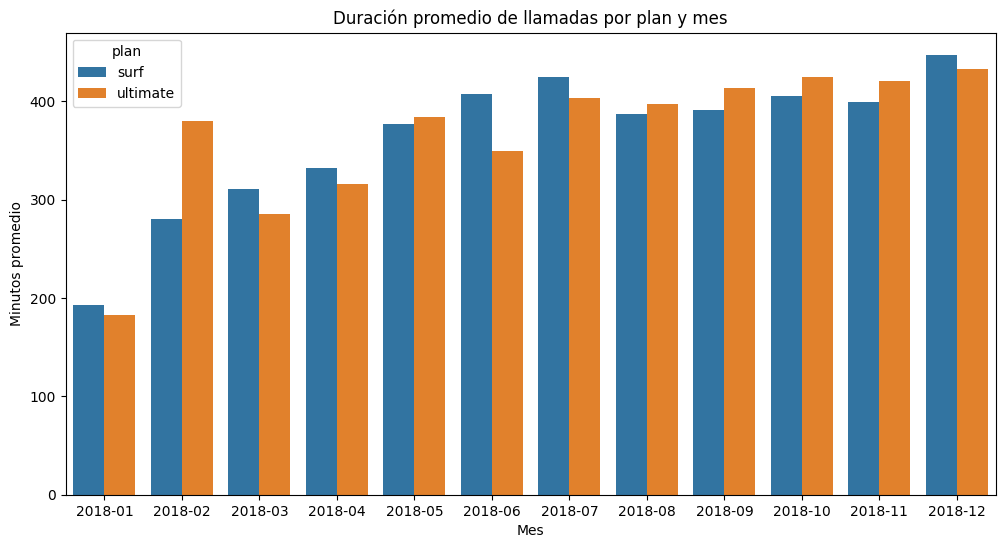

In [91]:
avg_call_duration = user_data.groupby(['plan', 'month'])['total_minutes'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x='month', y='total_minutes', hue='plan', data=avg_call_duration)
plt.title("Duración promedio de llamadas por plan y mes")
plt.ylabel("Minutos promedio")
plt.xlabel("Mes")
plt.show()



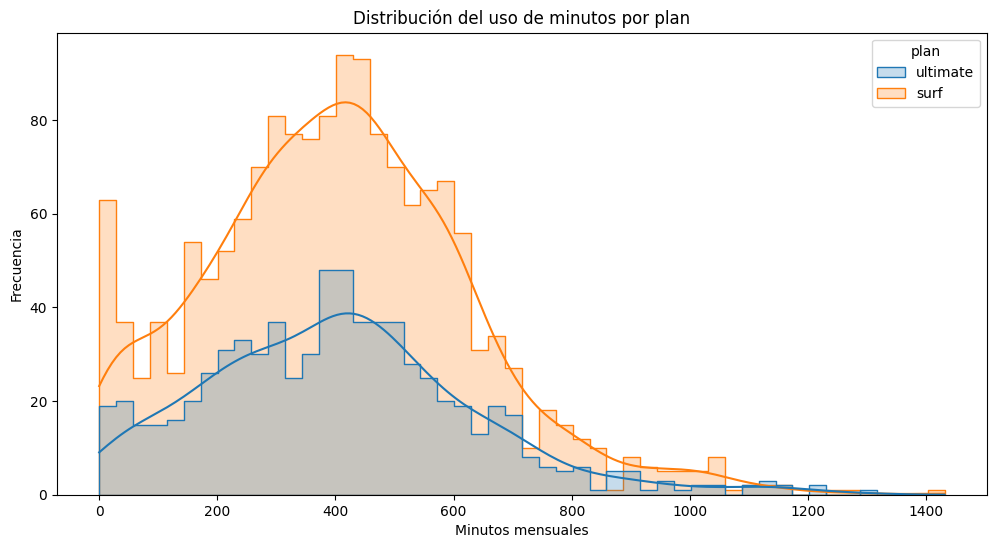

In [92]:
plt.figure(figsize=(12,6))
sns.histplot(data=user_data, x='total_minutes', hue='plan', bins=50, kde=True, element='step')
plt.title("Distribución del uso de minutos por plan")
plt.xlabel("Minutos mensuales")
plt.ylabel("Frecuencia")
plt.show()


In [93]:
stats_calls = user_data.groupby('plan')['total_minutes'].agg(['mean', 'var']).reset_index()
print(stats_calls)



       plan        mean           var
0      surf  404.762390  49135.104891
1  ultimate  406.193083  51640.971402


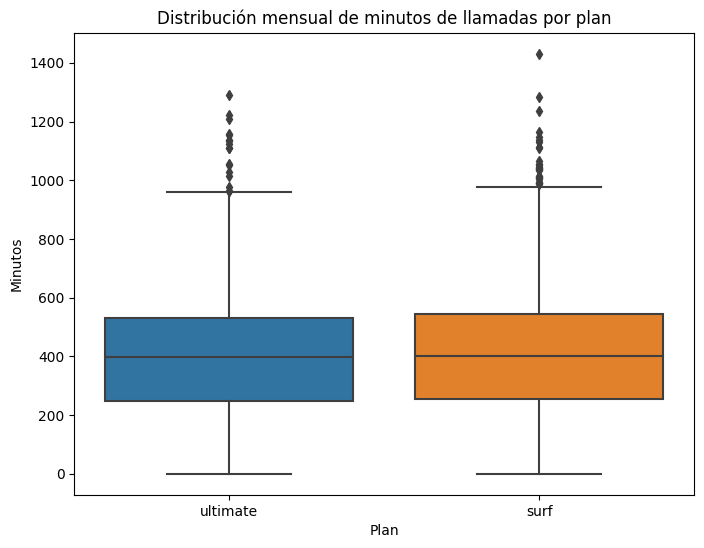

In [94]:
plt.figure(figsize=(8,6))
sns.boxplot(x='plan', y='total_minutes', data=user_data)
plt.title("Distribución mensual de minutos de llamadas por plan")
plt.ylabel("Minutos")
plt.xlabel("Plan")
plt.show()


El comportamiento de llamadas de los usuarios no varía significativamente entre planes: ambos muestran promedios similares y un patrón ascendente a lo largo del año. No obstante, el plan Surf concentra más casos de alto consumo (outliers), lo que podría implicar que ciertos clientes sobrepasan con mayor frecuencia los límites de su plan y, por lo tanto, generan cargos adicionales. En cambio, los usuarios de Ultimate se mantienen más estables, beneficiados por un límite mayor en su paquete.

### Mensajes

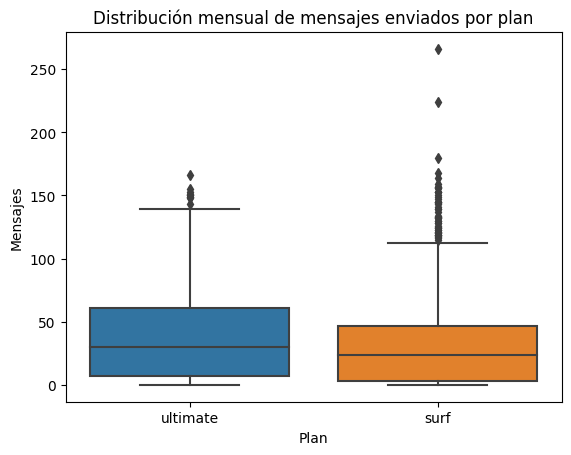

In [95]:
sns.boxplot(x='plan', y='messages_count', data=user_data)
plt.title("Distribución mensual de mensajes enviados por plan")
plt.ylabel("Mensajes")
plt.xlabel("Plan")
plt.show()


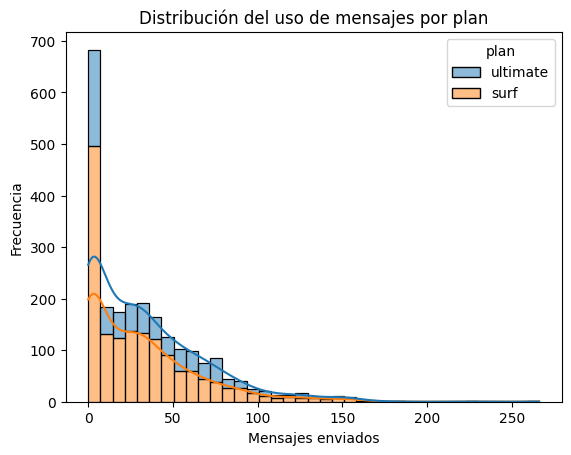

In [96]:
sns.histplot(data=user_data, x='messages_count', hue='plan', kde=True, multiple='stack')
plt.title("Distribución del uso de mensajes por plan")
plt.xlabel("Mensajes enviados")
plt.ylabel("Frecuencia")
plt.show()


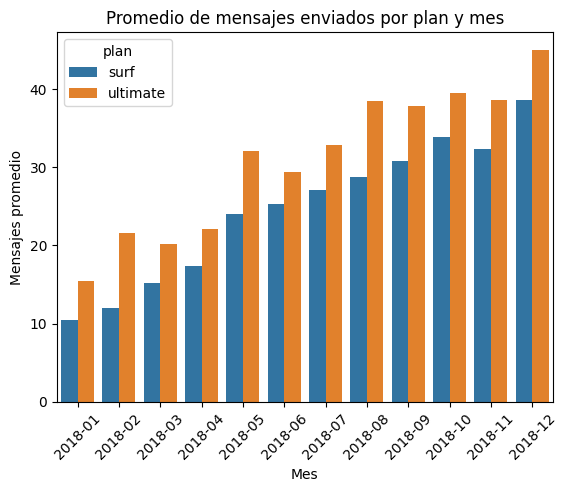

In [97]:
messages_avg = user_data.groupby(['month', 'plan'])['messages_count'].mean().reset_index()
sns.barplot(x='month', y='messages_count', hue='plan', data=messages_avg)
plt.title("Promedio de mensajes enviados por plan y mes")
plt.ylabel("Mensajes promedio")
plt.xlabel("Mes")
plt.xticks(rotation=45)
plt.show()

El comportamiento de los usuarios en cuanto al envío de mensajes sí varía según el plan contratado.
Los clientes del plan Ultimate tienden a enviar más mensajes que los del plan Surf, tanto en mediana como en promedio mensual. Además, la tendencia muestra que con el paso del tiempo los usuarios de ambos planes incrementaron su uso, pero este crecimiento fue más notable en el plan Ultimate.

### Internet

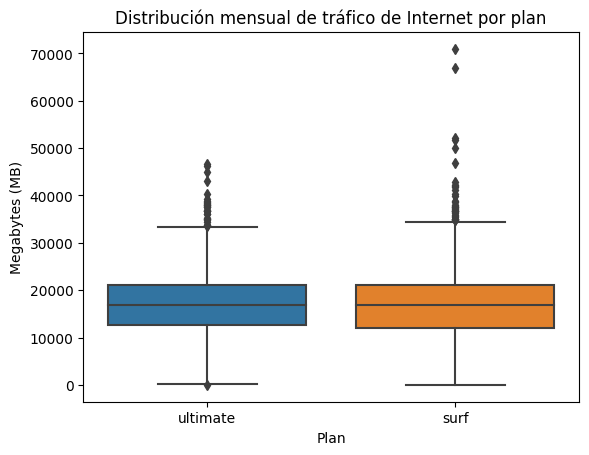

In [98]:
sns.boxplot(x='plan', y='total_mb', data=user_data)
plt.title("Distribución mensual de tráfico de Internet por plan")
plt.xlabel("Plan")
plt.ylabel("Megabytes (MB)")
plt.show()

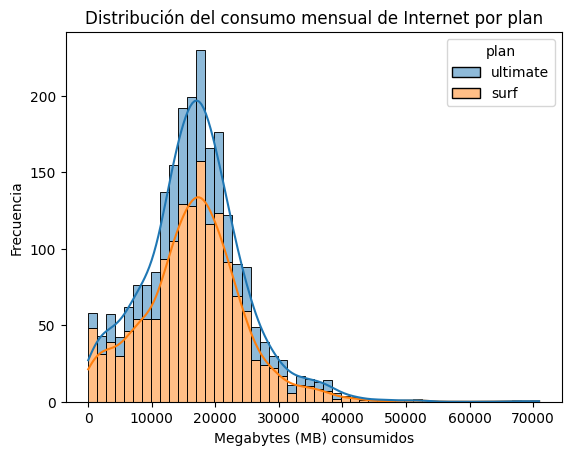

In [99]:
sns.histplot(data=user_data, x='total_mb', hue='plan', kde=True, bins=50, multiple="stack")
plt.title("Distribución del consumo mensual de Internet por plan")
plt.xlabel("Megabytes (MB) consumidos")
plt.ylabel("Frecuencia")
plt.show()

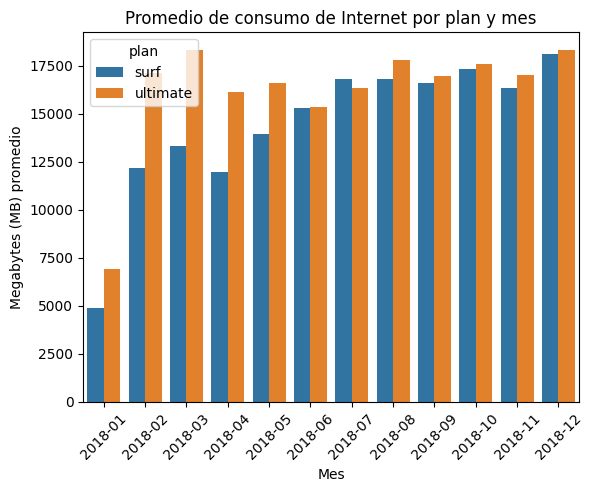

In [100]:
internet_avg = user_data.groupby(['month', 'plan'])['total_mb'].mean().reset_index()

sns.barplot(x='month', y='total_mb', hue='plan', data=internet_avg)
plt.title("Promedio de consumo de Internet por plan y mes")
plt.xlabel("Mes")
plt.ylabel("Megabytes (MB) promedio")
plt.xticks(rotation=45)
plt.show()

Los usuarios del plan Ultimate consumen más Internet en promedio que los de Surf, aunque ambos grupos muestran un aumento sostenido en su uso a lo largo del tiempo. El mayor consumo en Ultimate puede explicarse porque al tener más beneficios incluidos, los clientes tienden a usarlo sin tantas restricciones.

## Ingreso

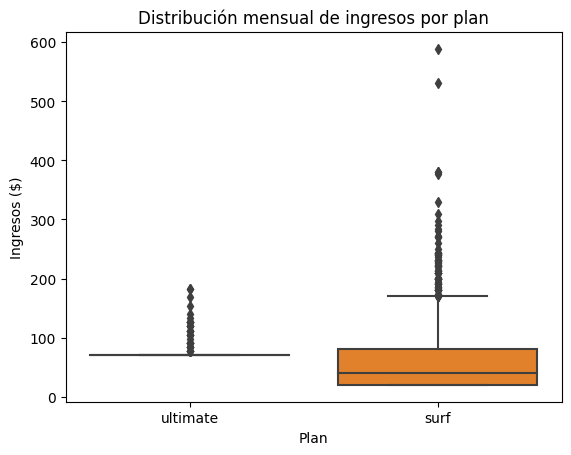

In [101]:
sns.boxplot(x='plan', y='monthly_revenue', data=user_data)
plt.title("Distribución mensual de ingresos por plan")
plt.ylabel("Ingresos ($)")
plt.xlabel("Plan")
plt.show()

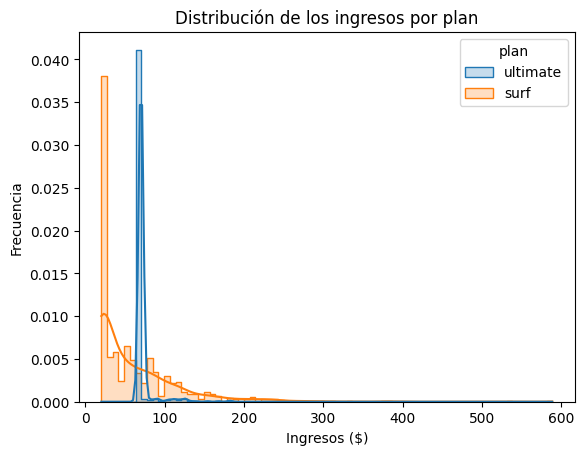

In [102]:
sns.histplot(user_data, x='monthly_revenue', hue='plan', kde=True, element='step', stat='density')
plt.title("Distribución de los ingresos por plan")
plt.xlabel("Ingresos ($)")
plt.ylabel("Frecuencia")
plt.show()

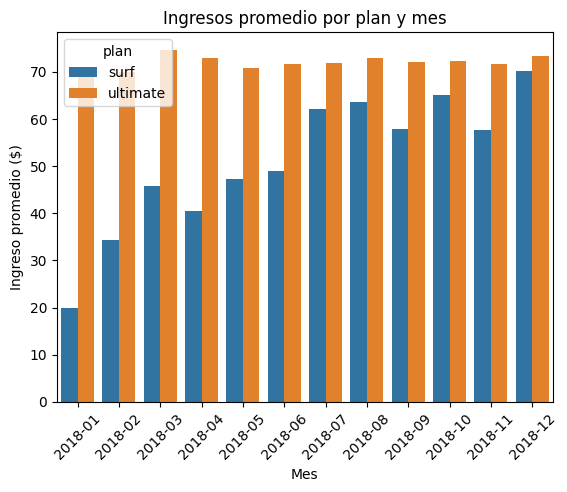

In [103]:
revenue_avg = user_data.groupby(['month', 'plan'])['monthly_revenue'].mean().reset_index()

sns.barplot(x='month', y='monthly_revenue', hue='plan', data=revenue_avg)
plt.title("Ingresos promedio por plan y mes")
plt.ylabel("Ingreso promedio ($)")
plt.xlabel("Mes")
plt.xticks(rotation=45)
plt.show()

El plan Ultimate asegura ingresos estables y consistentes para la compañía, mientras que el plan Surf es más variable: muchos clientes pagan menos, pero existe un grupo que incrementa fuertemente el ingreso al exceder sus límites, lo que hace que hacia final de año los ingresos promedio de Surf se acerquen a los de Ultimate. Esto indica que, aunque Ultimate es más predecible, Surf puede resultar igual o más rentable en el largo plazo por los excedentes.

## Prueba las hipótesis estadísticas

In [104]:
ultimate_revenue = user_data[user_data['plan'] == 'ultimate']['monthly_revenue']
surf_revenue = user_data[user_data['plan'] == 'surf']['monthly_revenue']

t_stat, p_value = stats.ttest_ind(ultimate_revenue, surf_revenue, equal_var=False)

print("Estadístico t:", t_stat)
print("p-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print("Rechazamos la hipótesis nula: los ingresos promedio son significativamente diferentes.")
else:
    print("No se puede rechazar la hipótesis nula: no hay diferencias significativas en los ingresos promedio.")


Estadístico t: 8.228840784742438
p-value: 3.5320199509520717e-16
Rechazamos la hipótesis nula: los ingresos promedio son significativamente diferentes.


In [111]:
# Agregar la información de ciudad al DataFrame user_data
user_data = user_data.merge(users[['user_id', 'city']], on='user_id', how='left')

# Verificar que se agregó correctamente
print("Columnas después del merge:")
print(user_data.columns.tolist())


ny_nj_revenue = user_data[user_data['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA']['monthly_revenue']
other_revenue = user_data[user_data['city'] != 'New York-Newark-Jersey City, NY-NJ-PA MSA']['monthly_revenue']

# Aplicamos t-test (Welch por defecto con equal_var=False)
t_stat, p_value = stats.ttest_ind(ny_nj_revenue, other_revenue, equal_var=False)

print("Estadístico t:", t_stat)
print("p-value:", p_value)

# Interpretación con alfa = 0.05
alpha = 0.05
if p_value < alpha:
    print("Rechazamos H₀: existe diferencia significativa en el ingreso promedio entre NY-NJ y otras regiones.")
else:
    print("No se puede rechazar H₀: no hay evidencia de diferencia significativa en el ingreso promedio.")


Columnas después del merge:
['user_id', 'month', 'calls_count', 'total_minutes', 'messages_count', 'total_mb', 'plan', 'messages_included', 'mb_per_month_included', 'minutes_included', 'usd_monthly_pay', 'usd_per_gb', 'usd_per_message', 'usd_per_minute', 'gb_included', 'usd_per_minute_included', 'usd_per_message_included', 'usd_per_gb_included', 'monthly_revenue', 'city_x', 'city_y', 'city_x', 'city_y', 'city_x', 'city_y', 'city']
Estadístico t: -2.1597353056435096
p-value: 0.031214139070912954
Rechazamos H₀: existe diferencia significativa en el ingreso promedio entre NY-NJ y otras regiones.


## Conclusión general

En este proyecto se integraron y analizaron datos de llamadas, mensajes, tráfico de Internet e ingresos mensuales de los clientes de Megaline. Para garantizar la comparabilidad, se procesaron los datos a nivel de usuario y mes, calculando métricas clave como minutos de llamadas, número de mensajes enviados, consumo de Internet en MB y los ingresos generados por cada cliente. Durante la preparación de datos fue necesario limpiar duplicados, estandarizar formatos y unificar variables de diferentes tablas. Esta decisión metodológica permitió obtener una visión homogénea y confiable del comportamiento de los usuarios.
El análisis descriptivo mostró que los usuarios de ambos planes, Surf y Ultimate, presentan patrones de uso diferentes. En las llamadas, la duración mensual promedio es bastante similar entre planes, aunque con mayor dispersión en Surf. En el caso de los mensajes, se observó que la mayoría de clientes de ambos planes envía pocos mensajes, pero los usuarios del plan Ultimate tienden a enviar un número mayor en promedio. El consumo de Internet, en cambio, resultó ser el servicio más relevante: ambos planes muestran un crecimiento sostenido a lo largo del año, con los usuarios de Ultimate consumiendo ligeramente más datos en promedio.
Respecto a los ingresos, el plan Ultimate generó valores más estables gracias a su tarifa fija más alta, lo que asegura un flujo predecible para la empresa. El plan Surf, en contraste, presentó una alta variabilidad: mientras algunos usuarios con bajo consumo pagan poco, aquellos que superan los límites incluidos terminan generando ingresos muy superiores, en algunos casos incluso mayores que los obtenidos en el plan Ultimate. Esto confirma que Surf es un plan más arriesgado desde el punto de vista de la empresa, pero también con un alto potencial de rentabilidad en determinados clientes.
Las pruebas estadísticas reforzaron estas conclusiones. Se aplicaron pruebas t de Welch, dado que los grupos presentaban varianzas distintas, con un nivel de significancia de 0.05. Los resultados confirmaron que existe una diferencia significativa en los ingresos promedio entre los planes Surf y Ultimate, siendo Ultimate el que más ingresos genera en promedio. Sin embargo, al analizar las diferencias entre los ingresos de los usuarios en el área de NY-NJ y los de otras regiones, no se encontró evidencia de una diferencia estadísticamente significativa, lo cual indica que la ubicación geográfica no tiene un impacto directo en los ingresos generados.
En síntesis, el plan Ultimate garantiza ingresos más altos y estables, mientras que Surf resulta más volátil pero con la posibilidad de generar grandes ingresos en usuarios intensivos en datos. Además, se comprobó que el tráfico de Internet es el factor más determinante en los ingresos totales, mucho más que las llamadas o los mensajes. No se identificaron diferencias regionales significativas en los ingresos de los clientes.
Con base en estos resultados, se recomienda a Megaline enfocar su estrategia comercial en promover el plan Ultimate como una opción segura y confiable, ideal para usuarios que buscan despreocuparse de los límites de consumo. Al mismo tiempo, resulta conveniente mantener el plan Surf como una alternativa atractiva para usuarios de bajo consumo, pero prestando especial atención a los clientes intensivos en datos, quienes representan una oportunidad clave para aumentar los ingresos de la empresa.